In this notebooks, I implemented decision tree in terms of (1) choosing split attributes by information gain; (2) recursively growing tree; (3) prune tree by regularized cost function; (4) plot tree; (5) inference

Author: Kunqi Jiang <br/>
Date: 7/15/2018

In [631]:
import numpy as np
from collections import Counter as count
from collections import defaultdict

In [643]:
attributes_label = {'年龄':{'青年':0,'中年':1,'老年':2},
                    '工作':{'无':0,'有':1},
                    '房子':{'无':0,'有':1},
                    '信用':{'一般':0,'好':1,'非常好':2},
                    '类别':{'否':0, '是':1}}

attr_index = {0:'Age',1:'Work',2:'House',3:'Credit','leaf':'leaf'}
label_index = {0:'No',1:'Yes'}

# Note: last column is label
data_table = [[0,0,0,0,0],
              [0,0,0,1,0],
              [0,1,0,1,1],
              [0,1,1,0,1],
              [0,0,0,0,0],
              [1,0,0,0,0],
              [1,0,0,1,0],
              [1,1,1,1,1],
              [1,0,1,2,1],
              [1,0,1,2,1],
              [2,0,1,2,1],
              [2,0,1,1,1],
              [2,1,0,1,1],
              [2,1,0,2,1],
              [2,0,0,0,0],
              [1,0,0,0,1],
              [1,1,0,2,1],
              [0,1,1,1,0]]

In [633]:
class Node:
    def __init__(self,attrs,datas,parent,height):
        self.attrs = attrs
        self.datas = datas
        self.numData = len(datas)
        self.children = defaultdict(Node)
        self.split_attr = 'leaf'
        self.leaf = False
        self.parent = parent
        self.height = height
        
    # check if all labels same
    def pure(self,datas):
        labels = []
        for data in datas:
            labels.append(data[-1])
        if len(set(labels)) == 1:
            return True
        return False
    
    # labels distributes
    def distribute(self,datas):
        labels = []
        for d in datas:
            labels.append(d[-1])
        return count(labels)
    
    # take the majority as node label
    def majorVote(self):
        c = self.distribute(self.datas)
        return max(c,key=c.get)
    
    # calculate the entropy of node
    def entropy(self,datas):
        dist = self.distribute(datas)
        entropy = 0
        for c in dist.values():
            p = c/len(datas)
            entropy += -p*np.log(p)
        return entropy
    
    # calculate information gain split by an attribute
    def inforGain(self,datas,attr):
        entropy = self.entropy(datas)
        dk = defaultdict(list)
        # group datas in this node by the attribute
        for data in datas:
            dk[data[attr]].append(data)
        # calculate condictional entropy after split
        con_entropy = 0
        for attr, cate in dk.items():
            con_entropy += (len(cate)/len(datas)) * self.entropy(cate)
        return entropy - con_entropy 
    
    # find best available(not used) attribute to split
    # according to information gain
    def best_attr(self,datas):
        I = 0
        G = []
        for attr in self.attrs:
            G.append(self.inforGain(datas,attr))
        return self.attrs[G.index(max(G))]
    
    # split into children by given attribute
    def split(self,datas,attr):
        self.split_attr = attr
        attrs_left = [a for a in self.attrs if a is not attr]
        dk = defaultdict(list)
        for data in datas:
            dk[data[attr]].append(data)
        for key, group in dk.items():
            child = Node(attrs_left,group,self,self.height+1)
            self.children[key] = child # key is attr categories

In [634]:
class ID3:
    def __init__(self,attr_index):
        self.attr_index = attr_index
    
    def buildTree(self,root):
        # if all attr used up
        if len(root.attrs) == 0:
            root.leaf = True
            return root
        # if all labels same
        elif root.pure(root.datas):
            root.leaf = True
            return root
        else:
            choose_attr = root.best_attr(root.datas)
            root.split(root.datas,choose_attr)
            for child in root.children.values():
                self.buildTree(child) # recursively build tree
    
    def printTree(self,root):
        c = root.distribute(root.datas)
        print('Node: {} at height {} Labels: {}'.format(attr_index[root.split_attr],root.height,dict(c)))
        for child in root.children.values():
            self.printTree(child)
    
    # number of all leaf in a tree
    def numOfLeaf(self,root):
        if root.leaf:
            return 1
        else:
            return sum([self.numOfLeaf(child) for child in root.children.values()])
    
    # entropy of current tree
    def leafEntropy(self,root):
        if root.leaf:
            # weighted by number of data for pruning
            return root.numData * root.entropy(root.datas) 
        else:
            return sum([self.leafEntropy(child) for child in root.children.values()])
    
    # depth of a tree, leaf as depth 1
    def treeDepth(self,root):
        if root.leaf:
            return 1
        else:
            return max([self.treeDepth(child) for child in root.children.values()]) + 1
    
    # check if prune to this node by comparing 
    # overall loss(with leaf number regularization)
    def pruneToLeaf(self,root,a):
        # a is penalty parameter
        selfEntropy = root.numData * root.entropy(root.datas)
        numLeaf = numOfLeaf(root)
        leafEntro = leafEntropy(root)
        if selfEntropy + 1*a < leafEntro + numLeaf*a:
            root.children = defaultdict(Node)
            root.leaf = True
            root.split_attr = 'leaf'
    
    # bottom-up recurisively pruning
    ## Note: (1) top-down won't work here since the tree is overfit
    ##       during the generation, the over-all cost will be high
    ##       could easily be prune by upper node, while best tree 
    ##       should be somewhere in between.
    ##       (2) checking over-all cost when growing the tree might
    ##       short-sighted, missing good split after current split
    
    def prune(self,root,a):
        if root.leaf:
            parent = root.parent
            while(parent):
                pruneToLeaf(parent,a)
                parent = parent.parent
        else:
            # all way down to leaf
            [prune(child,a) for child in root.children.values()]
    
    # inference test data, return label
    def predict(self,root,infer):
        if root.leaf:
            c = root.distribute(root.datas)
            return max(c,key=c.get)
        else:
            root = root.children[infer[root.split_attr]]
            return self.predict(root,infer)


In [635]:
## Plotting methods
import matplotlib.pyplot as plt
import matplotlib as mpl

decisionNode = dict(boxstyle="round",color='#FF4040')
leafNode = dict(boxstyle="square",color='#7FFF00')
arrow_args = dict(arrowstyle="<-", color = '#FF8C00')
    
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,xycoords='axes fraction', 
             xytext=centerPt, textcoords='axes fraction', 
            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

In [636]:
def plotTree(root, parentPt, nodeTxt):
    # dynamically range the position of subtree
    numLeafs = numOfLeaf(root)
    # place current node in the middle of it children
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW,plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(attr_index[root.split_attr], cntrPt, parentPt, decisionNode)
    children = root.children
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in children.keys():
        if children[key].leaf:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(label_index[children[key].majorVote()], (plotTree.xOff, plotTree.yOff),cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
            
        else:
            plotTree(children[key],cntrPt,str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
    
def createPlot(root,model):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(model.numOfLeaf(root))
    plotTree.totalD = float(model.treeDepth(root))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(root, (0.5,1.0), '')
    plt.show()

### Build Tree

In [637]:
attributes = [0,1,2,3]
root = Node(attributes,data_table,None,1)
id3 = ID3(attr_index)
id3.buildTree(root)

Node: Credit at height 1 Labels: {0: 7, 1: 11}
Node: Work at height 2 Labels: {0: 4, 1: 2}
Node: Age at height 3 Labels: {0: 4, 1: 1}
Node: leaf at height 4 Labels: {0: 2}
Node: House at height 4 Labels: {0: 1, 1: 1}
Node: leaf at height 5 Labels: {0: 1, 1: 1}
Node: leaf at height 4 Labels: {0: 1}
Node: leaf at height 3 Labels: {1: 1}
Node: Age at height 2 Labels: {0: 3, 1: 4}
Node: Work at height 3 Labels: {0: 2, 1: 1}
Node: leaf at height 4 Labels: {0: 1}
Node: House at height 4 Labels: {0: 1, 1: 1}
Node: leaf at height 5 Labels: {1: 1}
Node: leaf at height 5 Labels: {0: 1}
Node: Work at height 3 Labels: {0: 1, 1: 1}
Node: leaf at height 4 Labels: {0: 1}
Node: leaf at height 4 Labels: {1: 1}
Node: leaf at height 3 Labels: {1: 2}
Node: leaf at height 2 Labels: {1: 5}


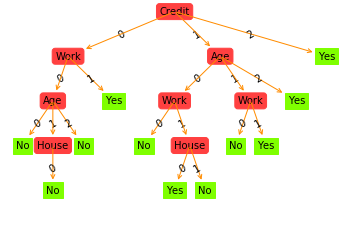

In [638]:
id3.printTree(root)
createPlot(root,id3)

### Prune Tree

In [639]:
id3.prune(root,1)

In [640]:
id3.printTree(root)

Node: Credit at height 1 Labels: {0: 7, 1: 11}
Node: Work at height 2 Labels: {0: 4, 1: 2}
Node: leaf at height 3 Labels: {0: 4, 1: 1}
Node: leaf at height 3 Labels: {1: 1}
Node: leaf at height 2 Labels: {0: 3, 1: 4}
Node: leaf at height 2 Labels: {1: 5}


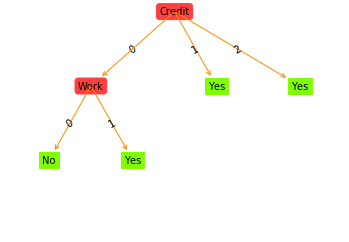

In [641]:
createPlot(root,id3)

### Inference

In [642]:
test = [0,0,0,0]
infer = id3.predict(root,test)
print('predict : ',label_index[infer])

predict :  No
